Let's initialize our environment

pip freeze:
conda==4.8.2
ipython==7.12.0
jupyter==1.0.0
matplotlib==3.1.3
numpy==1.18.1
pandas==1.0.1
py==1.8.1
scikit-image==0.16.2
scikit-learn==0.22.1
scipy==1.4.1
seaborn==0.10.0

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor

Read data into a Pandas DataFrame

In [2]:
data = pd.read_csv('insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Let’s have a look at data dimensionality, feature names and feature types<br>
Here is the description of our features:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


The last data column 'charges' is our target variable. It is a numerical feature. So we will use regression models for it

In [4]:
data['charges'].describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

Firstly, let's change categorical features into quantitative format. For binary feature 'smoker' will use map() function with dictionary

In [5]:
data['smoker'] = data['smoker'].map({'yes': 1,'no': 0})
data['sex'] = data['sex'].map({'female': 1,'male': 0})

In [6]:
data['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

For categorical feature 'region' will use get_dummies to make a binary column for each category with k-1 dummies out of k categorical levels (to remove collinearity of vectors)

In [7]:
data_new = pd.concat([data, pd.get_dummies(data['region'], prefix='region', drop_first=True)], axis=1)
data_new = data_new.drop(columns=['region'])

 Look at new feature types and names. Only numerical types and quantitative format

In [8]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1338 non-null   int64  
 1   sex               1338 non-null   int64  
 2   bmi               1338 non-null   float64
 3   children          1338 non-null   int64  
 4   smoker            1338 non-null   int64  
 5   charges           1338 non-null   float64
 6   region_northwest  1338 non-null   uint8  
 7   region_southeast  1338 non-null   uint8  
 8   region_southwest  1338 non-null   uint8  
dtypes: float64(2), int64(4), uint8(3)
memory usage: 66.8 KB


Build seaborn correlation matrix heatmap to visualize features' correlation with predictor and presence of correlation between other features

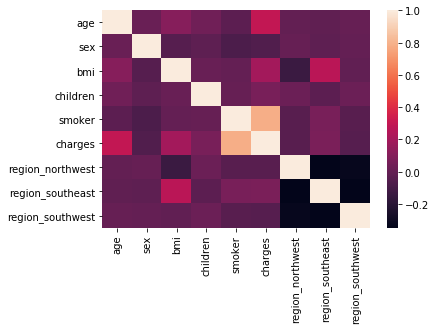

In [9]:
sns.heatmap(data_new.corr());

Let's take a look at the distribution of our features

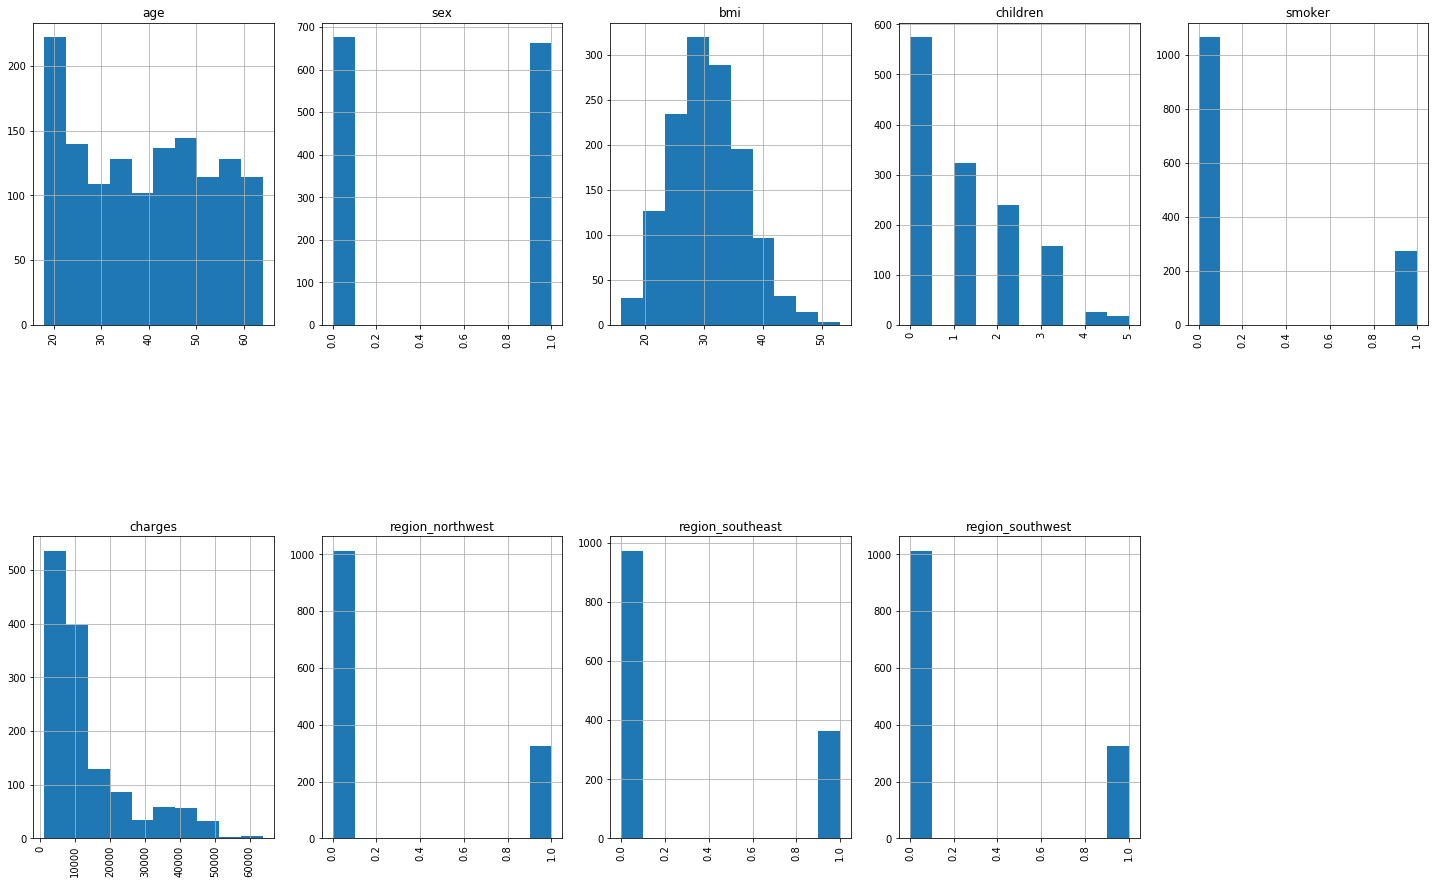

In [10]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = np.ceil(float(data_new.shape[1]) / cols)
for i, column in enumerate(data_new.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_new.dtypes[column] == np.object:
        data_new[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_new[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

Additional main features analysis

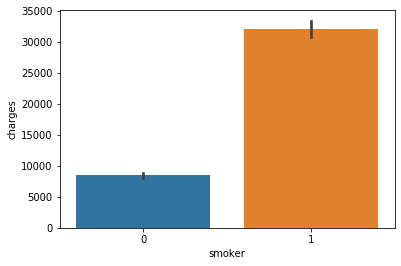

In [11]:
sns.barplot(x='smoker', y='charges', data=data_new);

This chart vividly illustrates the imbalance in our target variable for binary feature 'smoker'<br>
Now we can look at the distribution of our target according to value of 'smoker' feature

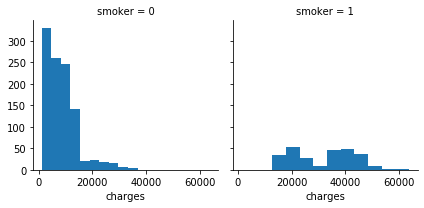

In [12]:
g = sns.FacetGrid(data_new, col='smoker')
g = g.map(plt.hist, 'charges');

We see that charges for non-smokers are often small and distributed in lower values, while charges of smokers range wide in higher values

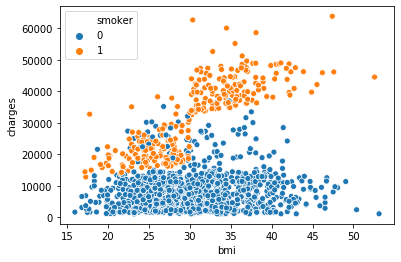

In [13]:
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=data_new);

Accoding this plot non-smokers have no obvious connection between 'charges' and 'bmi', while charges of smokers have tendency to increase with raising of bmi value

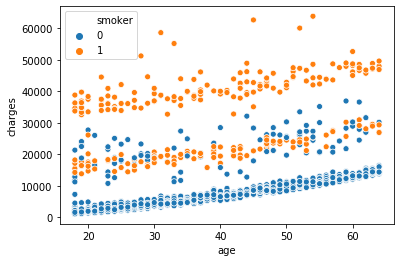

In [14]:
sns.scatterplot(x='age', y='charges', hue='smoker', data=data_new);

This plot shows that non-smokers have low charges for all age values, while smokers have higher charges

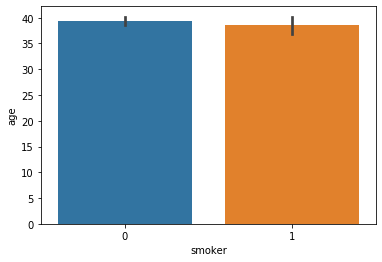

In [15]:
sns.barplot(x='smoker', y='age', data=data_new);

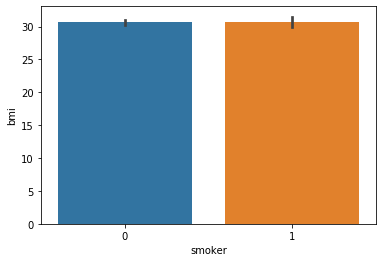

In [16]:
sns.barplot(x='smoker', y='bmi', data=data_new);

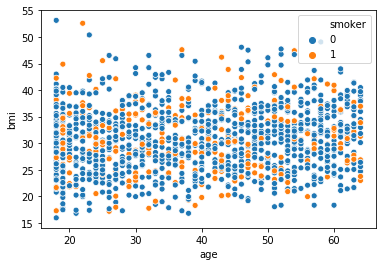

In [17]:
sns.scatterplot(x='age', y='bmi', hue='smoker', data=data_new);

According these plots mean values of age and bmi for smokers and non-smokers are close and there is no significant correlation between age and bmi for 'smoker' feature

Divide the dataset into the input and target

In [18]:
y = data_new['charges']

In [19]:
X = data_new.drop('charges', axis=1)

In [20]:
X.shape, y.shape

((1338, 8), (1338,))

In [21]:
X.head()

,age,sex,bmi,children,smoker,region_northwest,region_southeast,region_southwest
0,19,1,27.900,0,1,0,0,1
1,18,0,33.770,1,0,0,1,0
2,28,0,33.000,3,0,0,1,0
3,33,0,22.705,0,0,1,0,0
4,32,0,28.880,0,0,1,0,0


Let's allocate 70% of the set for training (X_train, y_train) and 30% for the hold-out set (X_holdout, y_holdout) using train_test_split

In [22]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=17)

Scaling of features can make the analysis of coefficients easier

In [23]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_holdout_scaled = scaler.transform(X_holdout)

Our target is a numerical feature and we use regression models for it<br>
We will assess prediction quality on our hold-out data using most popular metrics for regression models such as:
- R^2 (coefficient of determination) regression score function
- root mean squared error regression loss
- mean absolute error regression loss

In [24]:
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Look at the feature importancies and print the feature ranking

In [25]:
linreg_coef = pd.DataFrame({'feature': X.columns.values,
              'coef': linreg.coef_})
best_features_linreg = pd.DataFrame(linreg_coef.sort_values(by='coef', ascending=False).head(3), columns=['feature'])
linreg_coef.sort_values(by='coef', ascending=False)

,feature,coef
4,smoker,9987.305021
0,age,3499.287164
2,bmi,2109.461678
3,children,423.266801
1,sex,2.037150
5,region_northwest,-361.265559
7,region_southwest,-431.363598
6,region_southeast,-500.014676


In [26]:
print("Coefficient of determination: %.3f" % linreg.score(X_holdout_scaled, y_holdout))

Coefficient of determination: 0.734


In [27]:
lg_prediction_train = linreg.predict(X_train_scaled)
lg_prediction_holdout = linreg.predict(X_holdout_scaled)

In [28]:
RMSE_lg_train = np.sqrt(mean_squared_error(y_train, lg_prediction_train))
RMSE_lg_test = np.sqrt(mean_squared_error(y_holdout, lg_prediction_holdout))

In [29]:
print("Root mean squared error (train): %.3f" % RMSE_lg_train)
print("Root mean squared error (test): %.3f" % RMSE_lg_test)

Root mean squared error (train): 6210.735
Root mean squared error (test): 5689.531


In [30]:
MSA_lg_train = mean_absolute_error(y_train, lg_prediction_train)
MSA_lg_test = mean_absolute_error(y_holdout, lg_prediction_holdout)

In [31]:
print("Mean absolute error (train): %.3f" % MSA_lg_train)
print("Mean absolute error (test): %.3f" % MSA_lg_test)

Mean absolute error (train): 4276.727
Mean absolute error (test): 4054.541


In [32]:
alphas = np.arange(1, 100, 5)
ridge_cv = RidgeCV(cv=5, alphas=alphas)
ridge_cv.fit(X_train_scaled, y_train)

RidgeCV(alphas=array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81,
       86, 91, 96]),
        cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=False)

In [33]:
ridge_cv.alpha_

11

In [34]:
ridge_cv_coef = pd.DataFrame({'feature': X.columns.values,
              'coef': ridge_cv.coef_})
ridge_cv_coef.sort_values(by='coef', ascending=False)

,feature,coef
4,smoker,9868.901492
0,age,3457.642286
2,bmi,2086.800208
3,children,421.050737
1,sex,-8.635496
5,region_northwest,-349.203936
7,region_southwest,-418.265345
6,region_southeast,-471.622567


In [35]:
print("Coefficient of determination: %.3f" % ridge_cv.score(X_holdout_scaled, y_holdout))

Coefficient of determination: 0.736


In [36]:
ridge_cv_prediction_train = ridge_cv.predict(X_train_scaled)
ridge_cv_prediction_holdout = ridge_cv.predict(X_holdout_scaled)

In [37]:
RMSE_ridge_train = np.sqrt(mean_squared_error(y_train, ridge_cv_prediction_train))
RMSE_ridge_test = np.sqrt(mean_squared_error(y_holdout, ridge_cv_prediction_holdout))

In [38]:
print("Root mean squared error (train): %.3f" % RMSE_ridge_train)
print("Root mean squared error (test): %.3f" % RMSE_ridge_test)

Root mean squared error (train): 6212.044
Root mean squared error (test): 5676.016


In [39]:
MSA_ridge_train = mean_absolute_error(y_train, ridge_cv_prediction_train)
MSA_ridge_test = mean_absolute_error(y_holdout, ridge_cv_prediction_holdout)

In [40]:
print("Mean absolute error (train): %.3f" % MSA_ridge_train)
print("Mean absolute error (test): %.3f" % MSA_ridge_test)

Mean absolute error (train): 4298.930
Mean absolute error (test): 4066.024


In [41]:
lasso_cv = LassoCV(random_state=17, cv=5, alphas=alphas)
lasso_cv.fit(X_train_scaled, y_train)

LassoCV(alphas=array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81,
       86, 91, 96]),
        copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=17, selection='cyclic', tol=0.0001,
        verbose=False)

In [42]:
lasso_cv.alpha_

1

In [43]:
lasso_cv_coef = pd.DataFrame({'feature': X.columns.values,
              'coef': lasso_cv.coef_})
lasso_cv_coef.sort_values(by='coef', ascending=False)

,feature,coef
4,smoker,9986.208785
0,age,3498.484994
2,bmi,2107.934601
3,children,422.307622
1,sex,0.875778
5,region_northwest,-358.213157
7,region_southwest,-428.207409
6,region_southeast,-496.462219


In [44]:
print("Coefficient of determination: %.3f" % lasso_cv.score(X_holdout_scaled, y_holdout))

Coefficient of determination: 0.734


In [45]:
lasso_cv_prediction_train = lasso_cv.predict(X_train_scaled)
lasso_cv_prediction_holdout = lasso_cv.predict(X_holdout_scaled)

In [46]:
RMSE_lasso_train = np.sqrt(mean_squared_error(y_train, lasso_cv_prediction_train))
RMSE_lasso_test = np.sqrt(mean_squared_error(y_holdout, lasso_cv_prediction_holdout))

In [47]:
print("Root mean squared error (train): %.3f" % RMSE_lasso_train)
print("Root mean squared error (test): %.3f" % RMSE_lasso_test)

Root mean squared error (train): 6210.737
Root mean squared error (test): 5689.403


In [48]:
MSA_lasso_train = mean_absolute_error(y_train, lasso_cv_prediction_train)
MSA_lasso_test = mean_absolute_error(y_holdout, lasso_cv_prediction_holdout)

In [49]:
print("Mean absolute error (train): %.3f" % MSA_ridge_train)
print("Mean absolute error (test): %.3f" % MSA_ridge_test)

Mean absolute error (train): 4298.930
Mean absolute error (test): 4066.024


According recieved coefficients our linear models are overfitting in spite of using regularization

Initializing and train RandomForest model for regression task with default values and find coefficient of determination for it. For ensemble model we can use data without scaling

In [50]:
rf = RandomForestRegressor(random_state=17)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=17, verbose=0, warm_start=False)

In [51]:
print("Coefficient of determination: %.3f" % rf.score(X_holdout, y_holdout))

Coefficient of determination: 0.852


Now, let's identify the parameters for the tree using cross-validation. We'll tune the maximum depth, the minimum number of samples required to be at a leaf node and the maximum number of features used at each split

In [52]:
forest_params = {'max_depth': list(range(10, 18, 2)), 
                 'min_samples_leaf': list(range(4, 10)),
                 'max_features': list(range(4,8))}

locally_best_forest = GridSearchCV(rf, forest_params, cv=5, n_jobs=-1)
locally_best_forest.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=17,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [53]:
locally_best_forest.best_params_

{'max_depth': 12, 'max_features': 6, 'min_samples_leaf': 6}

Initializing and train RandomForest with best parameters

In [54]:
best_forest = RandomForestRegressor(max_depth=12, max_features=6, min_samples_leaf=6)
best_forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=12, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=6,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Find metrics for prediction quality assessment

In [55]:
print("Coefficient of determination: %.3f" % best_forest.score(X_holdout, y_holdout))

Coefficient of determination: 0.871


In [56]:
RMSE_rf_train = np.sqrt(mean_squared_error(y_train, best_forest.predict(X_train)))
RMSE_rf_train_cv = np.sqrt(abs(np.mean(cross_val_score(best_forest, X_train, y_train, 
                                                                    scoring='neg_mean_squared_error'))))
RMSE_rf_test = np.sqrt(mean_squared_error(y_holdout, best_forest.predict(X_holdout)))

In [57]:
print("Root mean squared error (train): %.3f" % RMSE_rf_train)
print("Root mean squared error (cv): %.3f" % RMSE_rf_train_cv)
print("Root mean squared error (test): %.3f" % RMSE_rf_test)

Root mean squared error (train): 3970.270
Root mean squared error (cv): 4825.516
Root mean squared error (test): 3964.710


In [58]:
MSA_rf_train = mean_absolute_error(y_train, best_forest.predict(X_train))
MSA_rf_test = mean_absolute_error(y_holdout, best_forest.predict(X_holdout))

In [59]:
print("Mean absolute error (train): %.3f" % MSA_rf_train)
print("Mean absolute error (test): %.3f" % MSA_rf_test)

Mean absolute error (train): 2223.933
Mean absolute error (test): 2359.194


The feature importancies of the forest. Print the feature ranking

In [60]:
forest_coef = pd.DataFrame({'feature': X.columns.values,
              'coef': best_forest.feature_importances_})
best_features_forest = pd.DataFrame(forest_coef.sort_values(by='coef', ascending=False).head(3), columns=['feature'])
forest_coef.sort_values(by='coef', ascending=False)

,feature,coef
4,smoker,0.712218
2,bmi,0.153933
0,age,0.114184
3,children,0.010905
6,region_southeast,0.003048
1,sex,0.002549
7,region_southwest,0.001874
5,region_northwest,0.001289


Now we can make models comparison

In [61]:
models_comparison = pd.DataFrame({
                    'model': ['LinearRegression', 'RandomForest'], 
                    'R^2': [linreg.score(X_holdout_scaled, y_holdout), best_forest.score(X_holdout, y_holdout)],
                    'RMSE(train)': [RMSE_lg_train, RMSE_rf_train],
                    'RMSE(test)': [RMSE_lg_test, RMSE_rf_test],
                    'MSA(train)': [MSA_lg_train, MSA_rf_train],
                    'MSA(test)': [MSA_lg_test, MSA_rf_test],
                    'main_features': [best_features_linreg['feature'].values, best_features_forest['feature'].values]})

In [62]:
models_comparison

,model,R^2,RMSE(train),RMSE(test),MSA(train),MSA(test),main_features
0,LinearRegression,0.734466,6210.735408,5689.531288,4276.726602,4054.541086,"[smoker, age, bmi]"
1,RandomForest,0.871059,3970.269578,3964.709581,2223.933153,2359.193953,"[smoker, bmi, age]"


In this case RandomForest works better than linear models<br>
The most important features for both models are **'smoker', 'bmi', 'age'**